# Card Classification

Each image we are assessing is exactly one card. For each image we want to determine the following properties:
1) **Colour**: Red, purple or green
2) **Count**: 1, 2 or 3
3) **Shape**: Oval, diamond or squiggle
4) **Fill**: Solid, hollow or shaded

I think it makes sense to first start with count. That way we can then zoom in on just one shape for determining the rest of the attributes. Meaning that the order of the rest of the classifcations will not matter. 

In [88]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def display_image(image, title=None, cmap=None, max_size=(800, 800)):
    """
    Display an image using matplotlib after resizing it to a smaller size.

    Parameters:
    - image: The image to display.
    - title: The title of the image (optional).
    - cmap: The colormap to use for displaying the image (optional).
    - max_size: The maximum size (width, height) to resize the image to (default is (400, 400)).
    """
    # Resize the image to fit within the max_size while maintaining the aspect ratio
    h, w = image.shape[:2]
    scaling_factor = min(max_size[0] / w, max_size[1] / h)
    new_size = (int(w * scaling_factor), int(h * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Convert color from BGR (OpenCV) to RGB (Matplotlib)
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(4, 4))  # Adjust the figsize to make the display smaller
    if title:
        plt.title(title)
    plt.imshow(resized_image, cmap=cmap)
    plt.axis('off')
    plt.show()

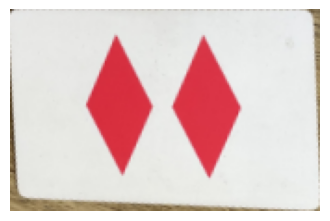

In [107]:
# Load the image using OpenCV
card = cv2.imread('./static/extracted_cards/card_6.png')
card = imutils.resize(card, width=500)

# Display the image
display_image(image=card)

## Count

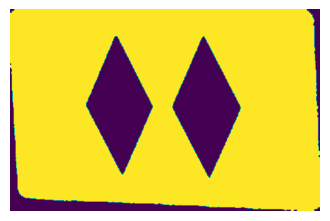

In [108]:
# Do some filtering to really make the shapes stand out.

# Apply grey scale filter
gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

# Gaussian blur the image.
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Otsu's threshold
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

display_image(thresh)

The card's Count is: 2


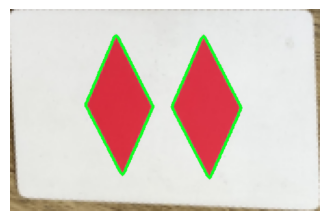

In [112]:
# Find contours and filter for cards using contour area.
# RETR_TREE: tries to find all contours.
cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_image = card.copy()

# We don't want to capture the smaller shapes, only the cards. So set a 
# threshold here. 
threshold_min_area = 400
rectangles = []
for i, contour in enumerate(cnts):
    parent_index = hierarchy[0][i][3]
    hasParent = parent_index != -1

    area = cv2.contourArea(contour)

    # Area of this contour itself is too small/large.
    if area < threshold_min_area or area > 30000: 
        continue

    # The parent doesn't if it is the border of the card.
    if hasParent and cv2.contourArea(cnts[parent_index]) < 30000:
        continue

    cv2.drawContours(contours_image, [contour], 0, (36,255,12), 3)

    rect = cv2.minAreaRect(contour)

    x, y, w, h = cv2.boundingRect(contour)
    rectangles.append((x, y, w, h))

count = len(rectangles)
print("The card's Count is:", count)

display_image(contours_image)

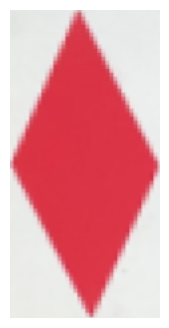

In [114]:

# From the above Count classifier, we can now just focus on one of the shapes.
# So use the collected rectangles and just zoom in on one shape.
x, y, w, h = rectangles[0]

shape_image = card[y:y+h, x:x+w]
display_image(shape_image)
